In [1]:
import xarray as xr
import numpy as np
import pandas as pd
from scipy.signal import periodogram
from scipy.stats import pearsonr
from scipy import ndimage as ndi
from skimage.feature import peak_local_max
from skimage.filters import sobel
from skimage.segmentation import watershed
from skimage.registration import optical_flow_ilk
from skimage.morphology import dilation, footprint_rectangle

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import colors

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

chlorophyll_filename = 'chl_cmems_obs-oc_glo_bgc-plankton_my_l4-gapfree-multi-4km_P1D.nc'
temperature_filename = 'thetao_cmems_mod_glo_phy-thetao_anfc_0.083deg_P1D-m.nc'
some_date = '1998-09-05'

## Data Loading and Preprocessing

In [2]:
df_chl = xr.open_dataset(chlorophyll_filename)
# print(df_chl.attrs)
# NOTE: The times are UTC
df_chl = df_chl.to_dataframe().reset_index()
print(df_chl.info())
print(df_chl.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158731776 entries, 0 to 158731775
Data columns (total 4 columns):
 #   Column     Dtype         
---  ------     -----         
 0   time       datetime64[ns]
 1   latitude   float32       
 2   longitude  float32       
 3   CHL        float32       
dtypes: datetime64[ns](1), float32(3)
memory usage: 3.0 GB
None
                                time      latitude     longitude           CHL
count                      158731776  1.587318e+08  1.587318e+08  9.789638e+07
mean   2011-02-23 12:00:00.000006144 -2.450000e+01 -7.100000e+01  4.832520e-01
min              1997-09-04 00:00:00 -2.797917e+01 -7.297916e+01  4.408028e-02
25%              2004-05-30 00:00:00 -2.623959e+01 -7.198958e+01  2.025560e-01
50%              2011-02-23 12:00:00 -2.450000e+01 -7.100000e+01  2.823514e-01
75%              2017-11-19 00:00:00 -2.276042e+01 -7.001041e+01  4.186009e-01
max              2024-08-14 00:00:00 -2.102084e+01 -6.902083e+01  6.500000e+01
st

In [3]:
# Get bounds
min_lat = df_chl.latitude.min()
max_lat = df_chl.latitude.max()
min_lon = df_chl.longitude.min()
max_lon = df_chl.longitude.max()
min_chl = df_chl.CHL.min()
max_chl = df_chl.CHL.max()

# Get the average step size from the data
step_lat = np.sort(df_chl.latitude.unique())
step_lat = np.mean(step_lat[1:] - step_lat[:-1])
step_lon = np.sort(df_chl.longitude.unique())
step_lon = np.mean(step_lon[1:] - step_lon[:-1])

# Use a factor to increase resolution
# step_lat *= 0.5
# step_lon *= 0.5

# Adjust latitude/longitude to indices on a fixed-size matrix
df_chl['lat_i'] = np.round((df_chl.latitude - min_lat) / step_lat).astype(np.uint32)
df_chl['lon_i'] = np.round((df_chl.longitude - min_lon) / step_lon).astype(np.uint32)

# Get matrix size
height = df_chl['lat_i'].max().item() + 1
width = df_chl['lon_i'].max().item() + 1

# Flip vertically the lattitude index
df_chl['lat_i'] = height - df_chl['lat_i'] - 1

# Group by index latitude and longitude
df_chl = df_chl.groupby(['time', 'lon_i', 'lat_i']).mean().reset_index()

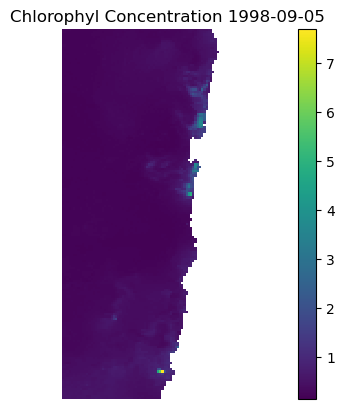

In [4]:
def make_mat(df, width, height, key):
    y = df['lat_i'].astype(np.uint32)
    x = df['lon_i'].astype(np.uint32)
    v = df[key].astype(np.float32)
    
    mat = np.zeros((height, width))
    mat[y, x] = v
    return mat

df_filtered = df_chl[df_chl['time'] == some_date]

mat = make_mat(df_filtered, width, height, 'CHL')

fig, ax = plt.subplots()
im = ax.imshow(mat, interpolation='none')
ax.set_title('Chlorophyl Concentration ' + some_date)
ax.set_axis_off()
fig.colorbar(im, ax=ax, orientation='vertical')
plt.show()

First interesting thing to note is that there are datapoints of chloropyll concentration on land represented by NaN in the sampled data.
Increasing the resolution artificially by applying a factor before performing data imputation does not appear to be an effective approach.

## Exploratory Data Analysis

In [5]:
start_date = df_chl['time'].min()
end_date = df_chl['time'].max()

full_range = pd.date_range(start=start_date, end=end_date, freq='D')
missing_dates = full_range.difference(df_chl['time'])

print('min_lat:', min_lat,
      'max_lat:', max_lat,
      'min_lon:', min_lon,
      'max_lon:', max_lon,
      'start_date:', start_date,
      'end_date:', end_date,
      'missing_dates:', len(missing_dates),
      'Number of days:', len(df_chl['time'].unique()))

min_lat: -27.979169845581055 max_lat: -21.020835876464844 min_lon: -72.97916412353516 max_lon: -69.02082824707031 start_date: 1997-09-04 00:00:00 end_date: 2024-08-14 00:00:00 missing_dates: 0 Number of days: 9842


The sampled area corresponds to the region between latitudes -27.9792 and -21.0208, and longitudes -72.9792 and -69.0208. The data consists of daily records from 1997-09-04 to 2024-08-14, with no missing days. A total of 9842 days.

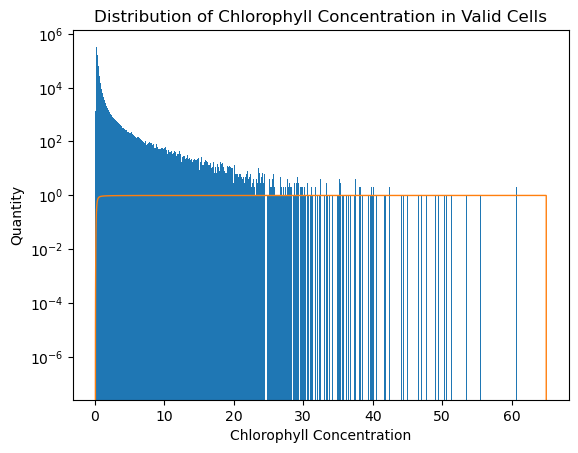

In [6]:
chl = df_chl['CHL']
chl = chl[~chl.isna()]

fig, ax = plt.subplots()
n, bins, patches = ax.hist(df_chl['CHL'], bins='auto', label='Raw')
n, bins, patches = ax.hist(df_chl['CHL'], bins=bins, density=True, histtype='step', cumulative=True, label='Cumulative')

ax.set_yscale('log')
ax.set_title("Distribution of Chlorophyll Concentration in Valid Cells")
ax.set_xlabel('Chlorophyll Concentration')
ax.set_ylabel('Quantity')
plt.show()

We examine the cumulative histogram for an elbow point that could suggest a threshold value above which chlorophyll concentrations may be considered unusually high.

In [7]:
df_notna = df_chl[['lon_i', 'lat_i', 'CHL']].copy()
df_notna['CHL'] = (~(df_notna['CHL'].isna())).astype(np.uint32)

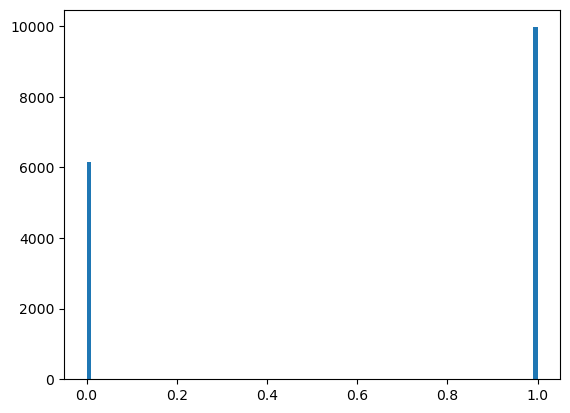

In [8]:
df = df_notna.groupby(['lon_i', 'lat_i']).sum().reset_index()
mat = make_mat(df, width, height, 'CHL')
mat = (mat - mat.min()) / (mat.max() - mat.min())
_ = plt.hist(mat.flatten(), bins=100)
landmask = np.logical_not(mat > 0.95)

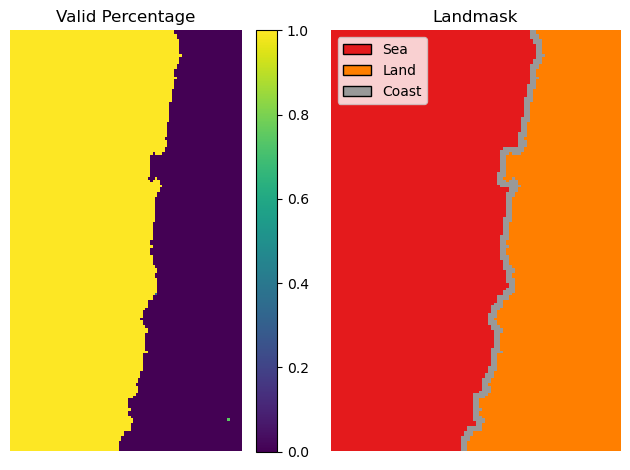

In [9]:
fig, axs = plt.subplots(ncols=2, sharex=True, sharey=True)

im = axs[0].imshow(mat, interpolation='none', aspect="auto")
fig.colorbar(im, ax=axs[0], orientation='vertical')
axs[0].set_title('Valid Percentage')

# Find the coastline
seacoast = dilation(landmask, footprint_rectangle((5, 5))) & ~landmask

mat_zones = landmask.copy().astype(np.uint8)
mat_zones[seacoast] = 2

im = axs[1].imshow(mat_zones, interpolation='none', cmap='Set1', aspect="auto")
axs[1].set_title('Landmask')

values = sorted(np.unique(mat_zones.ravel()))
legends = ['Sea', 'Land', 'Coast']
patches = [
    mpatches.Rectangle(
        xy=(0, 0),
        width=48,
        height=18,
        facecolor=im.cmap(im.norm(values[i])),
        label=legends[i],
        edgecolor='black')
    for i in range(len(values))
]
axs[1].legend(handles=patches, loc='upper left')

axs[0].set_axis_off()
axs[1].set_axis_off()

plt.tight_layout()
plt.show()

An outlier is visible over land, likely corresponding to a large inland water body. Initially, cells containing NaN values across all timestamps were classified as land, while other occurrences of NaN were treated as missing data. To improve robustness and reduce outliers, we instead classify a cell as land if the majority of its observations are NaN. In this case, a 95% threshold was applied.

## Time Series Analysis

We begin with a simple day-by-day analysis of average chlorophyll concentration, aiming to identify concentration peaks.

In [10]:
df = df_chl[df_chl['CHL'].notna()].groupby('time').mean().reset_index()
df = df.sort_values(by=['time'])

df['year'] = df['time'].dt.year
df['doy'] = df['time'].dt.dayofyear

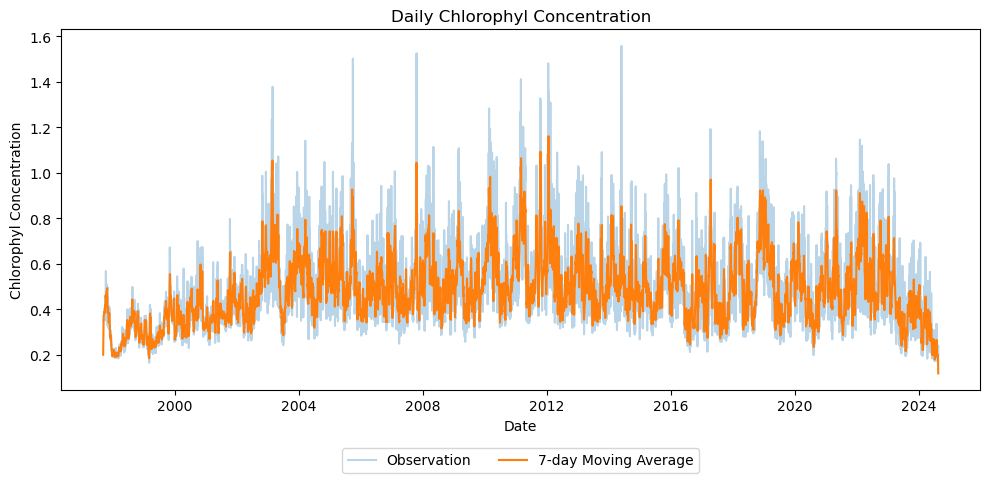

In [11]:
plt.figure(figsize=(10, 5))
ax = plt.gca()

ax.plot(df['time'], df['CHL'], alpha=0.3, label='Observation')
ax.plot(df['time'], np.convolve(df['CHL'], np.ones(7) / 7, mode='same'), label='7-day Moving Average')
#ax.plot(df['time'], np.convolve(df['CHL'], np.ones(30) / 30, mode='same'), label='30-day Moving Average')

ax.set_xlabel('Date')
ax.set_ylabel('Chlorophyl Concentration')
ax.set_title('Daily Chlorophyl Concentration')
ax.legend(bbox_to_anchor=(0.5, -0.25), loc='lower center', ncols=3)
plt.tight_layout()
plt.show()

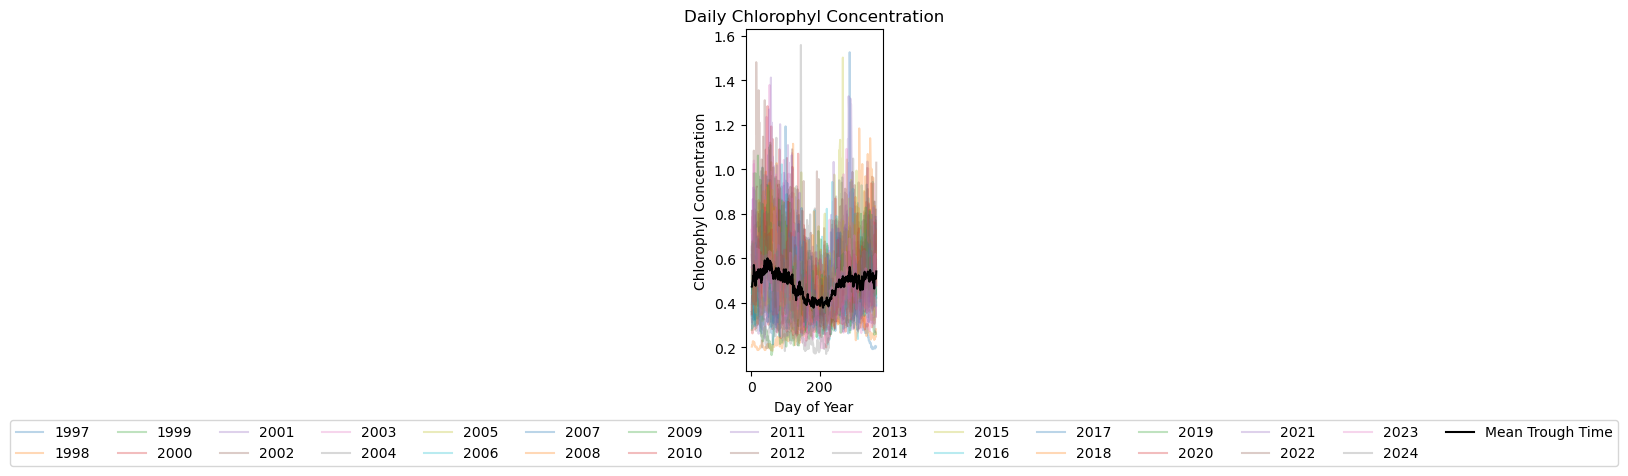

In [12]:
plt.figure(figsize=(10, 5))
ax = plt.gca()

for year, group in df.groupby('year'):
    ax.plot(group['doy'], group['CHL'], alpha=0.3, label=str(year))

df_temp = df[['doy', 'CHL']].groupby('doy').mean().reset_index()
ax.plot(df_temp['doy'], df_temp['CHL'], label='Mean Trough Time', c='black')

ax.set_xlabel('Day of Year')
ax.set_ylabel('Chlorophyl Concentration')
ax.set_title('Daily Chlorophyl Concentration')
ax.legend(loc='lower center', ncols=15, bbox_to_anchor=(0.5, -0.3))
plt.tight_layout()
plt.show()

The year-by-year plot does not reveal clear trends, so we will try aggregating the data into 5-year periods instead.

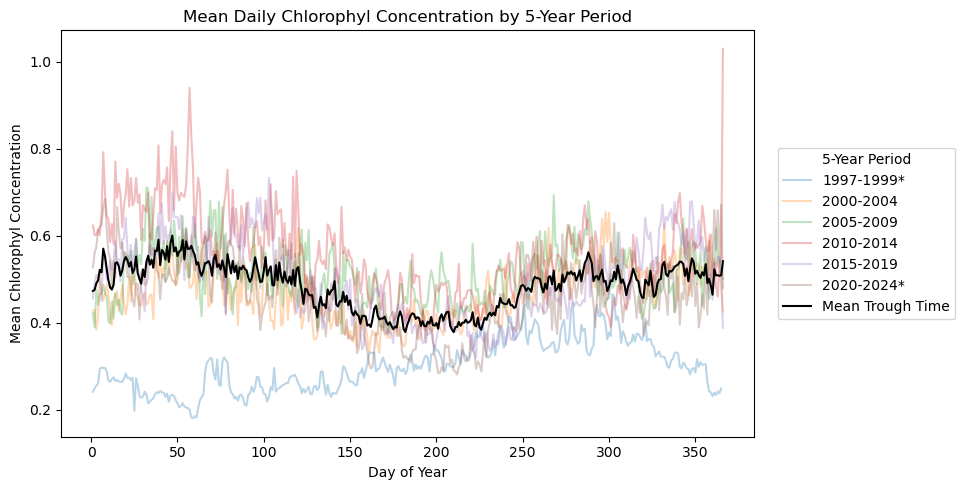

In [13]:
df['year_group'] = (df['year'] // 5) * 5
df['year_group_label'] = df['year_group'].astype(str) + '-' + (df['year_group'] + 4).astype(str)

# "Adjust the year grouping manually for shorter period
df.loc[df['year_group_label'] == '1995-1999', 'year_group_label'] = '1997-1999*'
df.loc[df['year_group_label'] == '2020-2024', 'year_group_label'] = '2020-2024*'

df_grouped = df.groupby(['year_group_label', df['time'].dt.dayofyear])['CHL'].mean().unstack(0)

plt.figure(figsize=(18, 5))
ax = plt.gca()

df_grouped.plot(figsize=(10, 5), alpha=0.3, ax=ax)

ax.plot(df_temp['doy'], df_temp['CHL'], label='Mean Trough Time', c='black')

ax.set_xlabel('Day of Year')
ax.set_ylabel('Mean Chlorophyl Concentration')
ax.set_title('Mean Daily Chlorophyl Concentration by 5-Year Period')
ax.legend(title='5-Year Period', loc='center right', ncols=1, bbox_to_anchor=(1.3, 0.5))
plt.tight_layout()
plt.show()

There appears to be a trend of higher chlorophyll concentrations at the start of the year, around day 50, which corresponds to February—a summer month in the Southern Hemisphere. The lowest concentration seems to occur around day 200, in July, a winter month in the Southern Hemisphere.
Let's try a different approach to see if the trend persists.

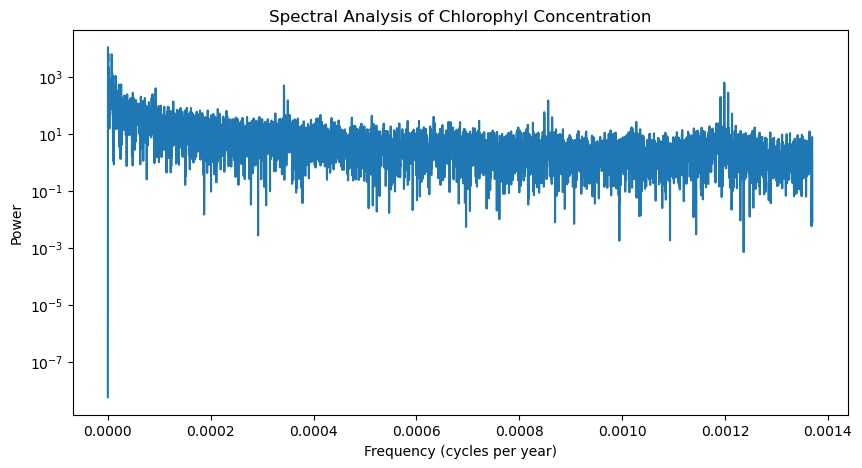

In [14]:
frequencies, power = periodogram(df['CHL'], fs=1./365.)

plt.figure(figsize=(10, 5))
ax = plt.gca()

ax.semilogy(frequencies, power)
ax.set_title("Spectral Analysis of Chlorophyl Concentration")
ax.set_xlabel("Frequency (cycles per year)")
ax.set_ylabel("Power")
plt.show()

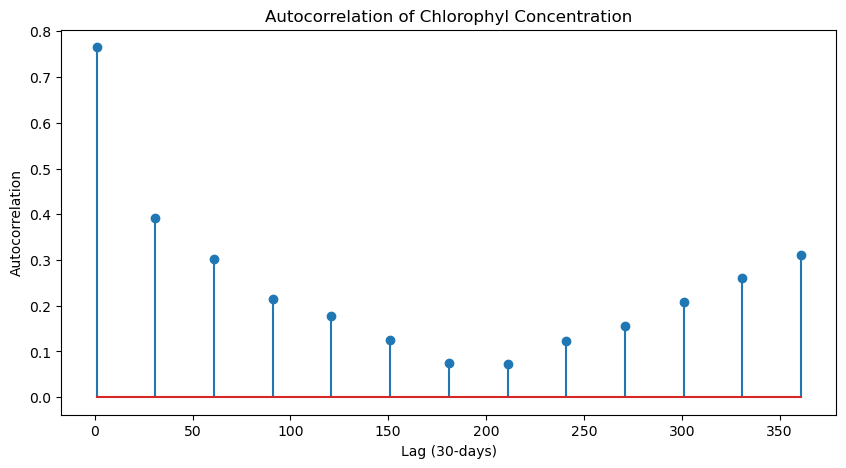

In [15]:
lags = range(1, 365, 30)
autocorrs = [pearsonr(df['CHL'][:-lag], df['CHL'][lag:])[0] for lag in lags]

plt.figure(figsize=(10, 5))
plt.stem(lags, autocorrs)
plt.title("Autocorrelation of Chlorophyl Concentration")
plt.xlabel("Lag (30-days)")
plt.ylabel("Autocorrelation")
plt.show()

Examining the autocorrelation, we can observe that the data samples are strongly correlated within a few months. This is expected, as chlorophyll concentration at a given time is likely to be related to nearby samples. Additionally, there is a slight increase in correlation on a yearly basis, likely due to seasonal factors.

## Spatial Analysis

Our goal is to identify regions with peak chlorophyll concentrations and focus our analysis on these areas.

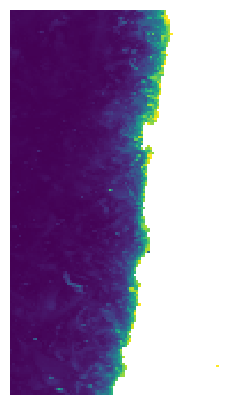

In [16]:
max_df = df_chl.groupby(['lon_i', 'lat_i']).max().reset_index()

mat_max = make_mat(max_df, width, height, 'CHL')

plt.figure(figsize=(10, 5))
ax = plt.gca()
ax.imshow(mat_max, interpolation='none')
ax.set_axis_off()

The naïve approach suggests that chlorophyll concentration peaks occur closer to the coast.

The previously selected date will be used to detect peaks at a fixed point in time.

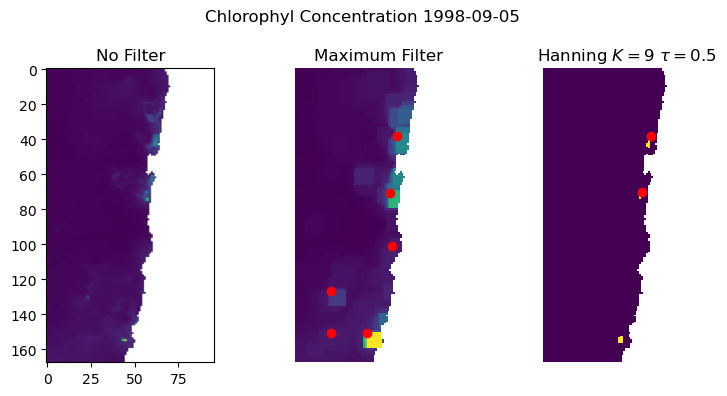

In [17]:
df = df_chl[df_chl['time'] == some_date]

mat = make_mat(df, width, height, 'CHL')
mat = (mat - min_chl) / (max_chl - min_chl)

# Find peaks using convolutional filters.
def get_kernel(size, fn=np.blackman):
    kernel = np.abs(fn(size))
    kernel = np.sqrt(np.outer(kernel, kernel))
    return kernel

fig, axs = plt.subplots(ncols=3, figsize=(8, 4))
axs = axs.flatten()

axs[0].imshow(mat)
axs[0].set_title('No Filter')

filtered = mat.copy()
filtered[np.isnan(filtered)] = 0.0

def plot_map(mat, title, ax):
    coord = peak_local_max(mat, min_distance=15)
    
    mat[landmask] = None
    ax.imshow(mat, interpolation='none')
    ax.set_title(title)
    ax.set_axis_off()
    
    if coord.size > 0:
        y, x = zip(*coord)
        ax.scatter(x, y, c='red')

# Maximum Filter
max_filter = ndi.maximum_filter(filtered, size=9, mode='nearest')
plot_map(max_filter, 'Maximum Filter', axs[1])

# Hanning
kernel = get_kernel(9, fn=np.hanning)
# han_filter = np.clip(ndi.convolve(mat, kernel), 0.5, 1)
han_filter = (ndi.convolve(mat, kernel) > 0.5).astype(np.float32)
plot_map(han_filter, 'Hanning $K=9\\ \\tau=0.5$', axs[2])

fig.suptitle('Chlorophyl Concentration ' + some_date)
plt.tight_layout()
plt.show()

At the moment have only chequed a single snippet of time. Lets Find the peaks along time, first lets check the change between two consecutive days

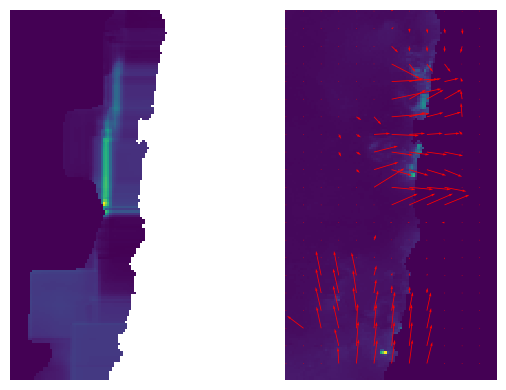

In [18]:
df1 = df_chl[df_chl['time'] == '1998-09-05']
df2 = df_chl[df_chl['time'] == '1998-09-06']

mat1 = make_mat(df1, width, height, 'CHL')
mat1 = (mat1 - min_chl) / (max_chl - min_chl)

mat2 = make_mat(df2, width, height, 'CHL')
mat2 = (mat2 - min_chl) / (max_chl - min_chl)

mat1[np.isnan(mat1)] = 0.0
mat2[np.isnan(mat2)] = 0.0

v, u = optical_flow_ilk(mat2, mat1, radius=15)
norm = np.sqrt(u**2 + v**2)
norm[landmask] = None

nvec = 20
step = max(height // nvec, width // nvec)

y, x = np.mgrid[0:height:step, 0:width:step]
u_ = u[::step, ::step]
v_ = v[::step, ::step]

fig, axs = plt.subplots(1, 2, figsize=(6, 4))
axs[0].imshow(norm, interpolation='none')
axs[1].imshow(mat1, interpolation='none')
axs[1].quiver(x, y, u_, v_, color='r', units='dots', angles='xy', scale_units='xy', lw=3)
axs[0].set_axis_off()
axs[1].set_axis_off()
fig.tight_layout()
plt.show()